====data info====
p_neighbor:
tensor([[0.000000, 1.000000],
        [0.292893, 1.707107],
        [1.000000, 2.000000]])


p_focal:
tensor([1, 1])


1-0 angle:45.00000125223908
2-0 angle:90.00000250447816
2-1 angle:44.999994422049916


0 length:1.0
1 length:1.0
2 length:1.0


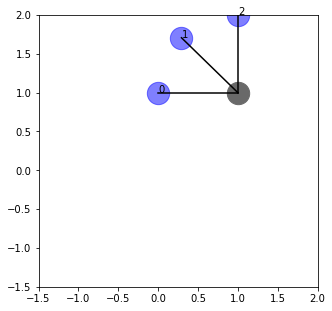

In [311]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
import math
from torch_geometric.data import Data
import numpy as np



def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):
        color = 'lightgrey'
    elif(atomic_num ==6):
        color = 'black'
    elif(atomic_num ==8):
        color = 'red'
    elif(atomic_num ==7):
        color = 'blue'
    return color

def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)
    

def vis(data = None, x_neighbor = None, x_focal = None, p_neighbor=None, p_focal=None, edge_attr_neighbor = None, vis_kernel=False):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)


    if data is not None:
        try:
            p_neighbor = data.p_neighbor
            p_focal = data.p_focal

        except:
            raise Exception('In data, either center position p_focal or position p is not provided')
                  
        try:
            x_neighbor = data.x_neighbor
        except:
            x_neighbor = None
        try:
            x_focal = data.x_focal
        except:
            x_focal = None
        try:
            edge_attr_neighbor = data.edge_attr_neighbor
        except:
            edge_attr_neighbor = None
    else:
        if p_neighbor is None or p_focal is None:
            raise Exception('either provide data, or provide both p_neighbor and p_focal is provided')
    
    if(vis_kernel==False):
        print('====data info====')

        print('p_neighbor:')
        print(p_neighbor)

        if x_neighbor is not None:
            print('\n')
            print('x_neighbor:')
            print(x_neighbor)

        if x_focal is not None:
            print('\n')
            print('x_focal:')
            print(x_focal)

        if p_focal is not None:
            print('\n')
            print('p_focal:')
            print(p_focal)

        if edge_attr_neighbor is not None:
            print('\n')
            print('edge_attr_neighbor:')
            print(edge_attr_neighbor)
    
    
    print('\n')
    s = p_neighbor.shape[0]
    calibrated_p_neighbor = p_neighbor-p_focal
    for i in range(s):
        for j in range(i):
            print(f'{i}-{j} angle:{angle_between_two_vectors(calibrated_p_neighbor[i], calibrated_p_neighbor[j])}')
    print('\n')
    
    for i in range(s):
        print(f'{i} length:{edge_length(calibrated_p_neighbor[i])}')
        
    print('=========')

    # annotate and color
    for i in range(p_neighbor.shape[0]):
        if x_neighbor is None or ( vis_kernel == True):
            plt.annotate(i, (p_neighbor[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x_neighbor[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p_neighbor[i,:]))
            marker_size = x_neighbor[i,2].item()*500
            color = color_for_element(atomic_num)
            
        # draw neighors
        plt.scatter(p_neighbor[i,0], p_neighbor[i,1], color = color, s = marker_size, alpha = 0.5)
        
    # draw focal    
    plt.scatter(p_focal[0], p_focal[1], color = 'dimgrey', s= marker_size)
    
    # draw bonds
    for each_p_neighbor in p_neighbor:
        plt.plot([each_p_neighbor[0], p_focal[0]],[each_p_neighbor[1],p_focal[1]], color = 'black')
    plt.show()    

def get_kernel_from_model(model):
    params = model.state_dict()
    for param in params:
        print(param)
    
    num_kernel_sets = int(len(params)/4)
    print(f'num_kernel_sets:{num_kernel_sets}')
    
    kernel_list = []
    for i in range(num_kernel_sets):

        x_center_array = params[f'kernel_set.{i}.x_center']
        x_support_array = params[f'kernel_set.{i}.x_support']
        edge_attr_support_array = params[f'kernel_set.{i}.edge_attr_support']
        p_support_array = params[f'kernel_set.{i}.p_support']
        output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
        kernel_list.append(output_kernel)
    return kernel_list


def vis_kernel(kernel):
    
    if isinstance(kernel, Data):
        kernel.x_neighbor = kernel.x_support

        kernel.p_neighbor = kernel.p_support  

        kernel.x_focal = kernel.x_center

        p_center = torch.tensor([0,0])    
        kernel.p_focal = p_center

        kernel.edge_attr = kernel.edge_attr_support


        print('====kernel info====')

        print('p_support:')
        print(p_support)

        if x is not None:
            print('\n')
            print('x_support:')
            print(x_support)

        if x_focal is not None:
            print('\n')
            print('x_center:')
            print(x_center)

        if p_focal is not None:
            print('\n')
            print('p_center:')
            print(p_center)

        if edge_attr is not None:
            print('\n')
            print('edge_attr_support:')
            print(edge_attr_support)


        vis(kernel, vis_kernel=True)
    elif isinstance(kernel, list):
        kernel_list = kernel
        for kernel in kernel_list:
            kernel.x_neighbor = kernel.x_support

            kernel.p_neighbor = kernel.p_support  

            kernel.x_focal = kernel.x_center

            p_center = torch.tensor([0,0])    
            kernel.p_focal = p_center

            kernel.edge_attr_neighbor = kernel.edge_attr_support


            print('====kernel info====')

            print('p_support:')
            print(kernel.p_support)

            if x is not None:
                print('\n')
                print('x_support:')
                print(kernel.x_neighbor)

            if x_focal is not None:
                print('\n')
                print('x_center:')
                print(kernel.x_focal)

            if p_focal is not None:
                print('\n')
                print('p_center:')
                print(kernel.p_focal)

            if edge_attr is not None:
                print('\n')
                print('edge_attr_support:')
                print(kernel.edge_attr_neighbor)


            vis(kernel, vis_kernel=True)
            
        
def vis_graph(data):
    fig_size = 5
    marker_size = 500
    lower_bound = -4
    upper_bound = 5
    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)
    
    
    x = data.x
    p = data.p
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    
    for i in range(x.shape[0]):
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x[i,0].item())
        color = color_for_element(atomic_num)
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
    

    for col in range(edge_index.shape[1]):
        start_idx = edge_index[0,col]
        end_idx = edge_index[1,col]
#         print(f'start_idx:{start_idx}, end_idx:{end_idx}')
        plt.plot([p[start_idx][0], p[end_idx][0]],  [p[start_idx][1],p[end_idx][1]], color = 'black')
    
    

    
def vis_kernel_in_model(model):
    kernel = get_kernel_from_model(model)
    if isinstance(kernel, Data):
        print(f'kernel:{kernel}')
        
    else:
        pass
        print('kernels:')
        for k in kernel:
            print(k)
    vis_kernel(kernel)

    
def rotate(p_center, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given p_center.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = p_center
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(p_center, points, angle):
    l = []
    for point in points:
        new_p = rotate(p_center, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)

def graph_rotate(data, p_center, angle):
    p = data.p
    new_p = tensor_rotate(p_center, p, angle)
    new_data = data.clone()
    new_data.p = new_p
    return new_data

# new_p = tensor_rotate(p_center, p, 180)
# # print(new_p)
# # vis(new_p, p_center)

# data_list = []
# for i in range(0, 370, 10):
#     new_p = tensor_rotate(p_center, p, i)
#     data = Data(p = new_p, p_center = p_center)
#     data_list.append(data)

# # for data in data_list:
# #     vis(data, p_center)


# translate
trans = torch.tensor([[1,1]])

# S = 3
x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_support = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)
p_support+=trans
p_center = torch.tensor([0,0]) + trans.squeeze(dim =0)


#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)


vis(p_neighbor = p_support, p_focal = p_center)
# model = KernelSetConv(D=2, node_attr_dim = 5, edge_attr_dim =1)
# vis_kernel_in_model(model)

calculating rdkit element representation lookup table
====data info====
p_neighbor:
tensor([[ 1.299038e+00,  7.500000e-01],
        [-1.299038e+00,  7.500000e-01],
        [-2.775558e-16, -1.500000e+00]])


x_neighbor:
tensor([[ 8.000000, 15.999000,  1.550000,  2.000000,  6.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000]])


x_focal:
tensor([ 6.000000, 12.011000,  1.700000,  4.000000,  4.000000])


p_focal:
tensor([-5.551115e-17, -5.551115e-17])


edge_attr_neighbor:
tensor([2, 1, 1])


1-0 angle:120.00000333930423
2-0 angle:120.00000333930423
2-1 angle:120.00000333930423


0 length:1.5
1 length:1.5
2 length:1.5


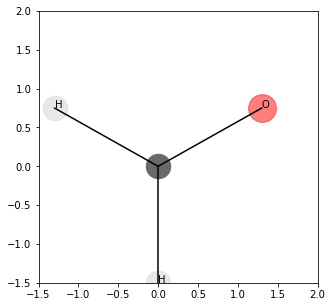

D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [68]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
import torch
from torch_geometric.data import Data

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
    global elem_lst

    if elem_lst is None:
        print('calculating rdkit element representation lookup table')
        elem_rep_lookup = []
        for elem in elements:
            pt = Chem.GetPeriodicTable() 

            if isinstance(elem, int):
                num=elem
                sym=pt.GetElementSymbol(num)
            else:
                num = pt.GetAtomicNumber(elem)
                sym = elem
            w = pt.GetAtomicWeight(elem)

            Rvdw = pt.GetRvdw(elem)
        #     Rcoval = pt.GetRCovalent(elem)
            valence = pt.GetDefaultValence(elem)
            outer_elec = pt.GetNOuterElecs(elem)

            elem_rep=[num, w,  Rvdw, valence, outer_elec]
#             print(elem_rep)


            elem_rep_lookup.append(elem_rep)
        elem_lst = elem_rep_lookup.copy()
        return elem_rep_lookup
    else:
        return elem_lst




def get_atom_rep(atomic_num, package='rdkit'):
    '''use rdkit or pymatgen to generate atom representation
    '''
    max_elem_num = 118
    element_nums= [x+1 for x in range(max_elem_num)]


    if package =='rdkit':
        elem_lst = lookup_from_rdkit(element_nums)
    elif package == 'pymatgen':
        raise Exception('pymatgen implementation is deprecated.')
        #elem_lst = lookup_from_pymatgen(element_nums)
    else:
        raise Exception('cannot generate atom representation lookup table')

    result = 0
    try:
        result = elem_lst[atomic_num - 1]
    except:
        print(f'error: atomic_num {atomic_num} does not exist')

    return result


def smiles2graph(D, smiles):
    if D==None:
        raise Exception('smiles2grpah() needs to input D to specifiy 2D or 3D graph generation.')
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    if D==2:
        rdkit.Chem.rdDepictor.Compute2DCoords(mol)
    if D==3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
    
    conf = mol.GetConformer()
    
    atom_pos = []
    atom_attr =[]
    
    # get atom attributes and positions
    for i, atom in enumerate(mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()
        h = get_atom_rep(atomic_num)
    
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
    
    # get bond attributes
    edge_list = []
    edge_attr_list =[]
    for idx, edge in enumerate(mol.GetBonds()):
        i = edge.GetBeginAtomIdx()
        j = edge.GetEndAtomIdx()
        
        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type ==Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type ==Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type ==Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type ==Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]     
            

        edge_list.append((i, j))
        edge_attr_list.append(bond_attr) 
#         print(f'i:{i} j:{j} bond_attr:{bond_attr}')

        edge_list.append((j, i))
        edge_attr_list.append(bond_attr)    
#         print(f'j:{j} j:{i} bond_attr:{bond_attr}')    
    
    x = torch.tensor(atom_attr)
    p = torch.tensor(atom_pos)
    edge_index = torch.tensor(edge_list).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list)
        
    return x, p, edge_index, edge_attr

smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()


# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
x_focal = None
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        p_focal = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
        x_focal = torch.tensor(h)
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
        
edge_attr = []
for j, edge in enumerate(mol.GetBonds()):
    bond_type = edge.GetBondType()
    if bond_type ==Chem.rdchem.BondType.SINGLE:
        edge_attr.append(1)
    elif bond_type ==Chem.rdchem.BondType.DOUBLE:
        edge_attr.append(2)
    elif bond_type ==Chem.rdchem.BondType.TRIPLE:
        edge_attr.append(3)
    elif bond_type ==Chem.rdchem.BondType.AROMATIC:
        edge_attr.append(4)
edge_attr = torch.tensor(edge_attr)
                              
p_neighbor = torch.tensor(atom_pos)
x_neighbor = torch.tensor(atom_attr)                              

# print(p)
# print(origin)
# print(x)
  
    
#============generate a list of same receptive field 
data = Data(p_neighbor=p_neighbor, x_neighbor=x_neighbor, x_focal=x_focal, edge_attr_neighbor=edge_attr, p_focal=p_focal)
# print(data)
vis(data=data)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(p_focal, p_neighbor, i)
    data = Data(p = new_p, p_focal = p_focal, x_neighbor=x_neighbor, x_focal = x_focal, edge_attr = edge_attr)
    data_list.append(data)
#     vis(data=data)





In [ ]:
# # conv with attributes
# # kernels
# from torch_geometric.nn import MessagePassing
# from torch_geometric.data import Data
# from torch_geometric.utils import degree

# import torch
# from torch.nn import CosineSimilarity, Module, ModuleList, Linear, Sigmoid
# from torch.nn.parameter import Parameter

# from itertools import permutations
# import math


# # kernel = Data(p_support = p_support)
# # same_kernel = Data(p_support = p)
# # sig = Sigmoid()



# class KernelConv(Module):
#     def __init__(self, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel:'type(Data)'=None):
#         super(KernelConv, self).__init__()
#         if init_kernel is None:
#             if (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
#                 raise Exception('either convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
#             else:
#                 init_kernel = Data(x_center = torch.randn(1, node_attr_dim),  x_support = torch.randn(num_supports,node_attr_dim), edge_attr_support = torch.randn(num_supports, edge_attr_dim), p_support = torch.randn(num_supports,D))

                
#         x_center_tensor = init_kernel.x_center
#         self.x_center = Parameter(x_center_tensor)

#         x_support_tensor = init_kernel.x_support
#         self.x_support = Parameter(x_support_tensor)
        
#         edge_attr_support_tensor = init_kernel.edge_attr_support
#         self.edge_attr_support = Parameter(edge_attr_support_tensor)
        
#         p_support_tensor = init_kernel.p_support
#         self.p_support = Parameter(p_support_tensor)
        

#     def permute(self, x):
#         rows = x.shape[0]
#         l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
#         return l        
        
#     def intra_angle(self,p:'shape(s,D)'):
#         '''
#         angles between each row vectors
#         ''' 
#         cos = CosineSimilarity(dim = 1)
#         new_p = torch.roll(p,1,0)
#         sc:'shape(s)' = cos(new_p, p)
        
#         return sc  
    
#     def get_angle_score(self, p, p_support):
#         cos = CosineSimilarity(dim = 0)
# #         print('p_dist:')
#         inter_p_dist = self.intra_angle(p)
# #         print('\n')
# #         print('s_dist:')
#         inter_p_support_dist = self.intra_angle(p_support)
# #         print(f'inter_p_support_dist:{inter_p_support_dist}')
#         sc = cos(inter_p_dist, inter_p_support_dist)
# #         sc = torch.dot(inter_p_dist, inter_p_support_dist.T)
# #         print(sc)
#         return sc

#     def get_length_score(self, p, p_support):
#         len_p = torch.norm(p, dim = -1)
#         len_p_support = torch.norm(p_support, dim = -1)
        
# #         print('len_p')
# #         print(len_p)
# #         print(len_p_support)
        
#         # inverse of L2 norm
#         diff = torch.square(len_p - len_p_support)
#         sc = torch.sum(diff)
#         sc = torch.atan(1/sc)
    
# #         print(sc)
#         return sc
    
#     def get_support_attribute_score(self, x_nei, x_support:'shape(s, d)'):

#         # inverse of L2 norm
# #         print('x_nei')
# #         print(x_nei)
# #         print('x_support')
# #         print(x_support)
#         diff = torch.square(x_nei - x_support)
#         sc = torch.sum(diff)
#         sc:'shape([])' = torch.atan(1/sc)
#         return sc
    
#     def get_center_attribute_score(self, x_focal, x_center):
#         # inverse of L2 norm
# #         print(f'center attri:{type(x_focal)}, {type(x_center)}')
# #         print(f'center attri:{x_focal.shape}, {x_center.shape}')
# #         print(x_focal)
# #         print(x_center)
#         diff = torch.square(x_focal - x_center)
#         sc = torch.sum(diff)
#         sc:'shape([])' = torch.atan(1/sc)
#         return sc
    
#     def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
# #         print('edge_attr_nei')
# #         print(edge_attr_nei)
# #         print('edge_attr_support')
# #         print(edge_attr_support)
#         diff = torch.square(edge_attr_nei - edge_attr_support)
#         sc = torch.sum(diff)
#         sc:'shape([])' = torch.atan(1/sc)
#         return sc
    
#     def forward(self, *argv, **kwargv):
#         if len(argv)!=0:
#             raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')
        
#         if len(kwargv) == 1:
#             x = kwargv['data'].x
#             edge_index = kwargv['data'].edge_index
#             edge_attr = kwargv['data'].edge_attr
#             p = kwargv['data'].p
#             x_focal = kwargv['data'].x_focal
#         else:
#             x = kwargv['x']
#             edge_index = kwargv['edge_index']
#             edge_attr = kwargv['edge_attr']
#             p = kwargv['p']
#             x_focal = kwargv['x_focal']
        
       
        
        
#         x_center = self.x_center
#         x_support = self.x_support
#         edge_attr_support = self.edge_attr_support
#         p_support = self.p_support            

#         #calibrate p
#         p = p-p_focal
        
#         # calculate the angle score
#         p_support_list = self.permute(p_support)
#         x_support_list = self.permute(x_support)
#         edge_attr_support_list = self.permute(edge_attr_support)
     
#         best_angle_sc = torch.tensor(-float('Inf'))
#         best_angle_sc_index = 0
#         for i, each_p_support in enumerate(p_support_list):
#             angle_sc = self.get_angle_score(p, each_p_support)

#             if angle_sc > best_angle_sc:
#                 best_angle_sc_index = i
#                 best_angle_sc = angle_sc
        
#         # get the p and p_support combination that gives the best angle score
#         best_p_support = p_support_list[best_angle_sc_index]
#         # calculate the length score for the best combination
#         length_sc = self.get_length_score(p, best_p_support)

#         # calculate the support attribute score for the best combination
#         best_x_support = x_support_list[best_angle_sc_index]
#         supp_attr_sc = self.get_support_attribute_score(x, best_x_support)
        
#         # calculate the center attribute score
#         center_attr_sc = self.get_center_attribute_score(x_focal, x_center)
        
#         # calculate the edge attribute score
#         best_edge_attr_support = edge_attr_support_list[best_angle_sc_index]
#         edge_attr_support_sc = self.get_edge_attribute_score(edge_attr, best_edge_attr_support)
        
#         # calculate the edge attribute score
# #         edge_attr_supportc = self.get_edge_attribute_score(edge_attr_nei, edge_attr_support)
        
        
#         # convert each score to correct dimension
#         angle_sc = best_angle_sc.unsqueeze(dim = 0)
#         length_sc = length_sc.unsqueeze(dim = 0)
#         supp_attr_sc = supp_attr_sc.unsqueeze(dim=0)
#         center_attr_sc = center_attr_sc.unsqueeze(dim=0)
#         edge_attr_support_sc = edge_attr_support_sc.unsqueeze(dim=0)
        
        
#         max_atan = torch.tensor([math.pi/2]) # the maxium value a arctain function can get
#         one = torch.tensor([1])
        
#         sc = torch.atan(1/
#                         (torch.square(length_sc-max_atan) + 
#                          torch.square(angle_sc-one)  + 
#                          torch.square(supp_attr_sc-max_atan) +
#                          torch.square(center_attr_sc - max_atan)+
#                          torch.square(edge_attr_support_sc-max_atan)
#                                      ))
        
#         print('\n')
#         print(f'len sc:{length_sc.item()}')
#         print(f'angle sc:{best_angle_sc.item()}')
#         print(f'support attribute_sc:{supp_attr_sc.item()}')
#         print(f'edge attribute score:{edge_attr_support_sc.item()}')
#         print(f'total sc: {sc.item()}')
#         return sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


In [126]:
# reset kernel and check kernel before training with attributed data


#==================standard kernel===================
# # S = 3
# S = 3
# x_center = torch.tensor([[1]], dtype = torch.float)
# x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
# p_support = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)

# # # S = 4
# # # kernel
# # S = 4
# # x_center = torch.tensor([[1]], dtype = torch.float)
# # x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
# # p_support = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1], [math.sqrt(0.5), -math.sqrt(0.5)]], dtype = torch.float)
#======================================================

s =3

h_list = []
for i in range(s):
    h = get_atom_rep(8, 'rdkit')
    h_list.append(h)
x_support = torch.tensor(h_list)

p_support = torch.randn(s, 2)

x_center = torch.tensor(get_atom_rep(16, 'rdkit'))

edge_attr_support = torch.randn(3)

init_kernel = Data(x_center = x_center, x_support = x_support, p_support=p_support, edge_attr_support = edge_attr_support)

    
# randomize kernel
# model = KernelConv(init_kernel=init_kernel)
# vis_kernel_in_model(model)



In [ ]:
model(data=data)

========epoch 0========
deg:1
len_p_neighbor
torch.Size([4, 1])
torch.Size([4, 1])


len sc:tensor([[1.469415, 1.469414, 1.469415, 1.136504]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796, 1.570796, 1.570796, 1.570796]],
       grad_fn=<UnsqueezeBackward0>)
support attribute_sc:tensor([[[0.156142],
         [0.156142],
         [0.156142],
         [0.156142]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[0.383912],
         [0.383912],
         [0.383912],
         [0.383912]]], grad_fn=<UnsqueezeBackward0>)
total sc: 0.016655895859003067


RuntimeError: stack expects a non-empty TensorList

In [ ]:
# visualize kernel in the model

vis(data)

vis_kernel_in_model(model)

model(data=data)

In [ ]:
# # test of KernelSetConv

        
# kernelset_2d = KernelSetConv(D = 2, node_attr_dim = 5, edge_attr_dim = 1)
# for item in kernelset_2d.state_dict():
#     print(item)


In [307]:
# test of a graph

from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import ModuleList
from torch.nn import CosineSimilarity, Module, ModuleList, Linear, Sigmoid
from torch.nn.parameter import Parameter

from itertools import permutations
import math


class KernelConv(Module):
    def __init__(self, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel:'type(Data)'=None):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception('either convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center = torch.randn(1, node_attr_dim),  x_support = torch.randn(num_supports,node_attr_dim), edge_attr_support = torch.randn(2*num_supports, edge_attr_dim), p_support = torch.randn(num_supports,D))

                
        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor)
        
        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor)
        
        p_support_tensor = init_kernel.p_support
        print(f'p_support_tensor:{p_support_tensor.shape}')
        self.p_support = Parameter(p_support_tensor)
        

    def permute(self, x):
#         print('permute')
#         print('x')
#         print(x.shape)
        rows = x.shape[0]
        l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
        output = torch.stack(l)
#         print('permuted')
#         print(output.shape)
        return output       
        
    def intra_angle(self,p:'shape(num_nodes_of_deg, s,D)'):
        '''
        angles between each row vectors
        ''' 
        cos = CosineSimilarity(dim = -1)
        new_p = torch.roll(p,1,dims = 1)
#         print(f'p:')
#         print(p)
        sc:'shape(num_nodes_of_deg, s)' = cos(new_p, p)
#         print(f'intra angle sc:{sc}')
        return sc  
    
    def arctan_sc(self, tensor1, tensor2, dim = None):
        diff = torch.square(tensor1-tensor2)
#         print(diff)
        sc = torch.sum(diff, dim = dim)
        sc = torch.atan(1/sc)
        return sc
    
    def get_angle_score(self, p_neighbor, p_support):

#         p_neighbor = p_neighbor.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1],p_neighbor.shape[2])
#         p_support = p_support.unsqueeze(1).expand(p_support.shape[0],p_neighbor.shape[1],p_support.shape[1],p_support.shape[2])

        
#         print('get_angle_score')
#         print('p_neighbor.shape')
#         print(p_neighbor.shape)
#         print('p_support.shape')
#         print(p_support.shape)
        if(p_support.shape[1]==1):
            return torch.full((p_support.shape[0], 1), math.pi/2)
        cos = CosineSimilarity(dim = 1)

        intra_p_neighbor_dist = self.intra_angle(p_neighbor)
        intra_p_neighbor_dist = intra_p_neighbor_dist.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1])
#         print(f'intra_p_neighbor_dist:{intra_p_neighbor_dist.shape}')
        
        intra_p_support_dist = self.intra_angle(p_support)
        intra_p_support_dist = intra_p_support_dist.unsqueeze(1).expand(p_support.shape[0], p_neighbor.shape[0],p_support.shape[1])
#         print(f'intra_p_support_dist:{intra_p_support_dist.shape}')

#         sc = cos(intra_p_neighbor_dist, intra_p_support_dist)
#         sc = torch.dot(intra_p_neighbor_dist, intra_p_support_dist.T)
        sc = self.arctan_sc(intra_p_neighbor_dist, intra_p_support_dist, dim = 2)
#         print(f'angle_sc:{sc}')
        return sc

    def get_length_score(self, p_neighbor, p_support):
        len_p_neighbor = torch.norm(p_neighbor, dim = -1)
        len_p_support = torch.norm(p_support, dim = -1)
        
#         print('len_p_neighbor')
#         print(len_p_neighbor.shape)
#         print(len_p_support.shape)
        
        # inverse of L2 norm
        sc = self.arctan_sc(len_p_neighbor, len_p_support, dim = 1)
#         diff = torch.square(len_p_neighbor - len_p_support)
#         sc = torch.sum(diff)
#         sc = torch.atan(1/sc)
    
# #         print(sc)
        return sc
    
    def get_support_attribute_score(self, x_nei, x_support:'shape(s, d)'):

        # inverse of L2 norm
#         print('x_nei')
#         print(x_nei)
#         print('x_support')
#         print(x_support)
#         diff = torch.square(x_nei - x_support)
#         sc = torch.sum(diff)
#         sc:'shape([])' = torch.atan(1/sc)
        sc = self.arctan_sc(x_nei, x_support, dim = 1)
        return sc
    
    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
#         print(f'center attri:{type(x_focal)}, {type(x_center)}')
#         print(f'center attri:{x_focal.shape}, {x_center.shape}')
#         print(x_focal)
#         print(x_center)
#         diff = torch.square(x_focal - x_center)
#         sc = torch.sum(diff)
#         sc:'shape([])' = torch.atan(1/sc)
        sc = self.arctan_sc(x_focal, x_center, dim=1)
        return sc
    
    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
#         print('edge_attr_nei')
#         print(edge_attr_nei)
#         print('edge_attr_support')
#         print(edge_attr_support)
#         diff = torch.square(edge_attr_nei - edge_attr_support)
#         sc = torch.sum(diff)
#         sc:'shape([])' = torch.atan(1/sc)
        sc = self.arctan_sc(edge_attr_nei, edge_attr_support, dim =1)
        return sc
    
    def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor):
        # calibrate p_neighbor
        p_neighbor = p_neighbor - p_focal
        
        # get kernel params
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support
        
#         print('cal total sc')
#         print('p_neighbor')
#         print(p_neighbor.shape)
#         print('p_support')
#         print(p_support)
        
        # calculate the angle score 
        permuted_p_support:'shape(num_permute, num_support, D)' = self.permute(p_support)
        

        angle_sc = self.get_angle_score(p_neighbor, permuted_p_support)
        best_angle_sc, best_angle_sc_index = torch.max(angle_sc, dim = 0)
#         print('angle_sc')
#         print(angle_sc)
#         print('best_angle_sc')
#         print(best_angle_sc)
#         print('best_angle_sc_index:')
#         print(best_angle_sc_index)
#         print(angle_sc)
    

        
        # get the p and p_support combination that gives the best angle score
        best_p_support = permuted_p_support[best_angle_sc_index]
        # calculate the length score for the best combination
        length_sc = self.get_length_score(p_neighbor, best_p_support)
#         print('length_sc')
#         print(length_sc)

        # calculate the support attribute score for the best combination
        permuted_x_support= self.permute(x_support)
        best_x_support = permuted_x_support[best_angle_sc_index]
        supp_attr_sc = self.get_support_attribute_score(x_neighbor, best_x_support)
#         print(supp_attr_sc)
        
        # calculate the center attribute score
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center)
#         print(center_attr_sc)
        
        # calculate the edge attribute score
        permuted_edge_attr_support = self.permute(edge_attr_support)
        best_edge_attr_support = permuted_edge_attr_support[best_angle_sc_index]   
        edge_attr_support_sc = self.get_edge_attribute_score(edge_attr_neighbor, best_edge_attr_support)
        
   
        
        # convert each score to correct dimension
        angle_sc = best_angle_sc.unsqueeze(dim = 0)
        length_sc = length_sc.unsqueeze(dim = 0)
        supp_attr_sc = supp_attr_sc.unsqueeze(dim=0)
        center_attr_sc = center_attr_sc.unsqueeze(dim=0)
        edge_attr_support_sc = edge_attr_support_sc.unsqueeze(dim=0)
        
        
        max_atan = torch.tensor([math.pi/2]) # the maxium value a arctain function can get
        one = torch.tensor([1])
        
        sc = torch.atan(1/
                torch.sum((torch.square(length_sc-max_atan) + 
                         torch.square(angle_sc-max_atan)  + 
                         torch.square(supp_attr_sc-max_atan) +
                         torch.square(center_attr_sc - max_atan)+
                         torch.square(edge_attr_support_sc-max_atan)
                                     )))
#         print('cal total sc')
#         print(sc)
        return sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc
    
   
    def forward(self, *argv, **kwargv):
        if len(kwargv) == 1:
            x_focal = kwargv['data'].x_focal
            p_focal = kwargv['data'].p_focal
            x_neighbor = kwargv['data'].x_neighbor
            p_neighbor = kwargv['data'].p_neighbor
            edge_attr_neighbor = kwargv['data'].edge_attr_neighbor
        else:
            x_focal = kwargv['x_focal']
            p_focal = kwargv['p_focal']
            x_neighbor = kwargv['x_neighbor']
            p_neighbor = kwargv['p_neighbor']
            edge_attr_neighbor = kwargv['edge_attr_neighbor']
        
            
#         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)
 

        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor)
        
        
        print('\n')
        print(f'len sc:{length_sc}')
        print(f'angle sc:{angle_sc}')
        print(f'support attribute_sc:{supp_attr_sc}')
        print(f'edge attribute score:{edge_attr_support_sc}')
        print(f'total sc: {sc}')
        return sc#, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


    
# =====test of KernelConv===
def print_data(data):
    print('x:')
    print(data.x)
    
    print('\n')
    print('p')
    print(data.p)
    
    print('\n')
    print('edge_index')
    print(data.edge_index)
    
    print('\n')
    print('edge_attr')
    print(data.edge_attr)



p_support_tensor:torch.Size([1, 2])
p_support_tensor:torch.Size([2, 2])
p_support_tensor:torch.Size([3, 2])
p_support_tensor:torch.Size([4, 2])


D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:325: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


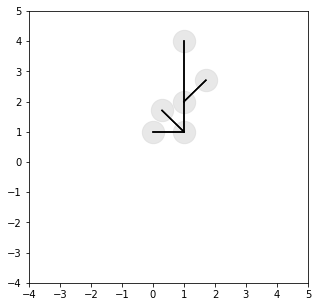

In [338]:
class KernelSetConv(Module):
    def __init__(self, D, node_attr_dim, edge_attr_dim):
        super(KernelSetConv, self).__init__()        
        
        kernel1 = KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel2 = KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel3 = KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel4 = KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
 
        self.kernel_set = ModuleList([kernel1, kernel2, kernel3, kernel4])

#         kernel_set = ModuleList(
#             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
#             ])

    def get_degree_index(self, x, edge_index):
        deg = degree(edge_index[0], x.shape[0])
        return deg
    
    def get_neighbor_index(self, edge_index, center_index):
#         print('edge_index')
#         print(edge_index)
#         print('\n')
#         print('center_index')
#         print(center_index)
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:,0] 
        return edge_index[1,d]
    
    def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
        '''
        outputs
        ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
        ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
        '''
        deg_index  = self.get_degree_index(x, edge_index)
        selected_index = (deg_index == deg).nonzero(as_tuple=True)
        x_focal = torch.index_select(input = x, dim = 0, index = selected_index[0]).unsqueeze(1)
        p_focal = torch.index_select(input = p, dim = 0, index = selected_index[0]).unsqueeze(1)
        
        return x_focal, p_focal

    def get_edge_attr_support_from_center_node(self, edge_attr, edge_index, center_index):
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:,0]

        # normalize bond id
        e = (d/2).long()
        bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
#         print('bond_id')
#         print(bond_id)

        # select bond attributes with the bond id
        nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)

        return nei_edge_attr    
    
    def get_neighbor_nodes_and_edges_of_degree(self, deg, x, p, edge_index, edge_attr):
        '''
        inputs:
        deg: the query degree
        num_focal: the number of focal nodes of degree deg in the graph
        
        outputs:
        nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
        num_focal = len(center_index)
#         print('center_index')
#         print(center_index)
        
        nei_x_list = []
        nei_p_list = []
        nei_edge_attr_list = []
        for i in range(num_focal):
            nei_index = self.get_neighbor_index(edge_index, center_index[i])
            
            nei_x = torch.index_select(x, 0, nei_index)
            nei_p = torch.index_select(p, 0, nei_index)
            nei_edge_attr = self.get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index[i])
#             print('\n nei_edge_attr')
#             print(nei_edge_attr)
            
            
            nei_x_list.append(nei_x)
            nei_p_list.append(nei_p)
            nei_edge_attr_list.append(nei_edge_attr)
            
        nei_x = torch.stack(nei_x_list, dim = 0)
        nei_p = torch.stack(nei_p_list, dim = 0)
        nei_edge_attr:'shape(num_focal, num_support*2, num_support_attr_dim)' = torch.stack(nei_edge_attr_list, dim = 0)
        
#         print('nei_edge_attr')
#         print(nei_edge_attr.shape)
        
        return nei_x, nei_p, nei_edge_attr
    
    def convert_graph_to_receptive_field(self, deg, x, p, edge_index, edge_attr):
        x_focal, p_focal = self.get_focal_nodes_of_degree(deg = deg, x = x, p=p, edge_index = edge_index)
        
        num_focal = x_focal.shape[0]
        if num_focal !=0:
            x_neighbor, p_neighbor, edge_attr_neighbor = self.get_neighbor_nodes_and_edges_of_degree(deg = deg, x = x, edge_index = edge_index, p=p, edge_attr = edge_attr)
#         print('x_neighbor')
#         print(x_neighbor) 
            return x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor
        return None
 
    def forward(self, *argv, **kwargv):
        '''
        inputs:
        data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
        '''
        if len(argv)!=0:
            raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')
        
        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p
          
        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']
        
#         print('edge_index')
#         print(edge_index)
        
#         print('edge_attr')
#         print(edge_attr)
            
        # loop through all possbile degrees. i.e. 1 to 4 bonds
        sc_list = []
        for deg in range(1,5):
#             print(f'deg:{deg}')
            receptive_field = self.convert_graph_to_receptive_field(deg, x, p, edge_index, edge_attr) 
#             print('receptive_field')
#             print(receptive_field)
            if receptive_field is not None:
                x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor = receptive_field[0], receptive_field[1], receptive_field[2], receptive_field[3], receptive_field[4]
                data = Data(x_focal=x_focal, p_focal=p_focal, x_neighbor=x_neighbor, p_neighbor=p_neighbor, edge_attr_neighbor=edge_attr_neighbor )

#             print('====data info====')
#             print('x_focal')
#             print(x_focal)
#             print('p_focal')
#             print(p_focal)
#             print('x_neighbor')
#             print(x_neighbor)
#             print('p_neighbor')
#             print(p_neighbor)
#             print('edge_attr_neighbor')
#             print(edge_attr_neighbor)
                sc = self.kernel_set[deg-1](data =data)
                
                
            else:
                sc= torch.tensor(0)
                max_atan = torch.tensor(math.pi/2) # the maxium value a arctain function can get
                sc = max_atan
            
            sc_list.append(sc)
        
        sc_list = torch.stack(sc_list)
#         print(f'sc_list:{sc_list}')
        return sc_list
        
        # a list containing the total score for all four kernels
#         kernel_score_list = [x(data = data) for x in self.kernel_set]
        
#         output = torch.cat([x(data = data) for x in self.kernel_set], dim=0)


# data prep
smiles = 'C(C(C=O)([H])[H])=S'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print_data(data)

# manual data for weird angle testing
trans = torch.tensor([[1,1]])
x= torch.tensor([[1],[1],[1],[1],[1],[1]], dtype = torch.float)
p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [0,0], [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p+=trans
edge_index = torch.tensor([[0,3,1,3,2,3, 5,2,2,4],[3,0,3,1,3,2,2,5,4,2]])
edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]])
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)

# ========generate a list of graphs
origin = torch.tensor([0,0])
vis_graph(data)
data_list = []
for i in range(0, 370, 10):
    data = graph_rotate(data, origin, i)
    data_list.append(data)
#     vis_graph(data)


# model prep
node_attr_dim = x.shape[1]
edge_attr_dim = edge_attr.shape[1]
model = KernelSetConv(D=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)


# examine the model kernel
# x_center = model.state_dict()['kernel_set.2.x_center']
# x_support = model.state_dict()['kernel_set.2.x_support']
# edge_attr_support = model.state_dict()['kernel_set.2.edge_attr_support']
# p_support = model.state_dict()['kernel_set.2.p_support']
# m_kernel = Data(x_center= x_center, x_support = x_support, edge_attr_support = edge_attr_support, p_support = p_support)
# vis_kernel(m_kernel) # this visualize one single kernel
# # vis_kernel_in_model(model) # this visualize all kernels in the model


# run
# model(data = data)


# KernelConv test

In [339]:
class KernelLayer(Module):
    def __init__(self, L, D, node_attr_dim, edge_attr_dim):
        '''
        inputs:
        D: dimension
        L: number of KernelConvSet 
        '''
        super(KernelLayer, self).__init__()
        self.kernelset_list = ModuleList()
        self.L = L
        for l in range(L):
            self.kernelset_list.append(KernelSetConv(D=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim))

    def forward(self, data):
        out = []
        for l in range(self.L):
            signal=self.kernelset_list[l](data=data)
            out.append(signal)
        print(out)
        

model = KernelLayer(2, 2, 5, 1)
model(data=data)

p_support_tensor:torch.Size([1, 2])
p_support_tensor:torch.Size([2, 2])
p_support_tensor:torch.Size([3, 2])
p_support_tensor:torch.Size([4, 2])
p_support_tensor:torch.Size([1, 2])
p_support_tensor:torch.Size([2, 2])
p_support_tensor:torch.Size([3, 2])
p_support_tensor:torch.Size([4, 2])


RuntimeError: The size of tensor a (4) must match the size of tensor b (5) at non-singleton dimension 2

In [327]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random
from tqdm import tqdm

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.5)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss


def train():
    random.shuffle(data_list)
    for data in data_list:
#         vis_graph(data)
#         sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = model(data=data)
        sc = model(data=data)
        label = torch.tensor([math.pi/2], dtype= torch.float)
        loss = criterion(sc, label)
        optimizer.zero_grad()
        
#         print('before')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
            
        loss.backward()
        optimizer.step()
        
#         print('after')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
        
    print('\n')
    print(f'loss:{loss.item()}')
#     print(f'len sc:{length_sc.item()}')
#     print(f'angle sc:{angle_sc.item()}')
#     print(f'support attribute_sc:{supp_attr_sc.item()}')
#     print(f'edge attribute score:{edge_attr_support_sc.item()}')
    print(f'label:{label}')
    print(f'total sc: {sc}')    

for i in range(20):
    print(f'========epoch {i}========')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_support_origin)
    


========epoch 0========


len sc:tensor([[0.820521, 0.820521, 0.820521, 0.820521]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[0.758218],
         [0.758218],
         [0.758218],
         [0.758218]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.212219],
         [1.212219],
         [1.212219],
         [1.212219]]], grad_fn=<UnsqueezeBackward0>)
total sc: 0.045531015843153


len sc:tensor([[1.363989, 1.363989, 1.363989, 1.363989]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.299340],
         [1.299340],
         [1.299340],
         [1.299340]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.426253],
         [1.426253],
         [1.426253],
         [1.426253]]], grad_fn=<UnsqueezeBackward0>)
total sc: 0.4264122247695923


len sc:tensor([[1.567368, 1.567368, 1.567368, 1.567368]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.

len sc:tensor([[1.566399, 1.566399, 1.566399, 1.566399]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.536554],
         [1.536554],
         [1.536554],
         [1.536554]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.554892],
         [1.554892],
         [1.554892],
         [1.554892]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5476828813552856


len sc:tensor([[1.567179, 1.567179, 1.567179, 1.567179]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.534726],
         [1.534726],
         [1.534726],
         [1.534726]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.552433],
         [1.552433],
         [1.552433],
         [1.552433]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.544366478919983


len sc:tensor([[1.567784, 1.567784, 1.567784, 1.567784]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribut

len sc:tensor([[1.570267, 1.570267, 1.570267, 1.570267]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.567681],
         [1.567681],
         [1.567681],
         [1.567681]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.565392],
         [1.565392],
         [1.565392],
         [1.565392]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5701489448547363


len sc:tensor([[1.570269, 1.570269, 1.570269, 1.570269]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.567744],
         [1.567744],
         [1.567744],
         [1.567744]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.565457],
         [1.565457],
         [1.565457],
         [1.565457]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.570167899131775


len sc:tensor([[1.570270, 1.570270, 1.570270, 1.570270]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribut

len sc:tensor([[1.570283, 1.570283, 1.570283, 1.570283]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568329],
         [1.568329],
         [1.568329],
         [1.568329]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.566226],
         [1.566226],
         [1.566226],
         [1.566226]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5703529119491577


len sc:tensor([[1.570283, 1.570283, 1.570283, 1.570283]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568331],
         [1.568331],
         [1.568331],
         [1.568331]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.566233],
         [1.566233],
         [1.566233],
         [1.566233]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5703541040420532


len sc:tensor([[1.570283, 1.570283, 1.570283, 1.570283]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribu



len sc:tensor([[1.570286, 1.570286, 1.570286, 1.570286]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568372],
         [1.568372],
         [1.568372],
         [1.568372]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.566459],
         [1.566459],
         [1.566459],
         [1.566459]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.570389986038208


len sc:tensor([[1.570286, 1.570286, 1.570286, 1.570286]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568373],
         [1.568373],
         [1.568373],
         [1.568373]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.566464],
         [1.566464],
         [1.566464],
         [1.566464]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5703908205032349


len sc:tensor([[1.570286, 1.570286, 1.570286, 1.570286]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attrib

edge attribute score:tensor([[[1.566655],
         [1.566655],
         [1.566655],
         [1.566655]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.570419192314148


len sc:tensor([[1.570290, 1.570290, 1.570290, 1.570290]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568404],
         [1.568404],
         [1.568404],
         [1.568404]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.566660],
         [1.566660],
         [1.566660],
         [1.566660]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5704199075698853


len sc:tensor([[1.570290, 1.570290, 1.570290, 1.570290]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568404],
         [1.568404],
         [1.568404],
         [1.568404]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.566665],
         [1.566665],
         [1.566665],
         [1.566665]]], grad_fn=<UnsqueezeBackward0>)
tota

edge attribute score:tensor([[[1.566837],
         [1.566837],
         [1.566837],
         [1.566837]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5704454183578491


len sc:tensor([[1.570293, 1.570293, 1.570293, 1.570293]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568434],
         [1.568434],
         [1.568434],
         [1.568434]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.566842],
         [1.566842],
         [1.566842],
         [1.566842]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5704461336135864


len sc:tensor([[1.570293, 1.570293, 1.570293, 1.570293]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568435],
         [1.568435],
         [1.568435],
         [1.568435]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.566847],
         [1.566847],
         [1.566847],
         [1.566847]]], grad_fn=<UnsqueezeBackward0>)
tot

len sc:tensor([[1.570296, 1.570296, 1.570297, 1.570297]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568466],
         [1.568466],
         [1.568466],
         [1.568466]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567015],
         [1.567015],
         [1.567015],
         [1.567015]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5704702138900757


len sc:tensor([[1.570297, 1.570297, 1.570297, 1.570297]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568467],
         [1.568467],
         [1.568467],
         [1.568467]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567019],
         [1.567019],
         [1.567019],
         [1.567019]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5704708099365234


len sc:tensor([[1.570297, 1.570297, 1.570297, 1.570297]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribu

support attribute_sc:tensor([[[1.568497],
         [1.568497],
         [1.568497],
         [1.568497]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567178],
         [1.567178],
         [1.567178],
         [1.567178]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.570492148399353


len sc:tensor([[1.570300, 1.570300, 1.570300, 1.570300]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568498],
         [1.568498],
         [1.568498],
         [1.568498]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567182],
         [1.567182],
         [1.567182],
         [1.567182]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5704926252365112


len sc:tensor([[1.570300, 1.570300, 1.570300, 1.570300]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568499],
         [1.568499],
         [1.568499],
         [1.568499]]], grad_fn=<UnsqueezeBackward0>)
edge

angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568528],
         [1.568528],
         [1.568528],
         [1.568528]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567327],
         [1.567327],
         [1.567327],
         [1.567327]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705115795135498


len sc:tensor([[1.570304, 1.570304, 1.570304, 1.570304]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568529],
         [1.568529],
         [1.568529],
         [1.568529]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567331],
         [1.567331],
         [1.567331],
         [1.567331]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705119371414185


len sc:tensor([[1.570304, 1.570304, 1.570304, 1.570304]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568530],
         [1.568530],
         [1.568530],
         [1.568530]]], gra



len sc:tensor([[1.570307, 1.570307, 1.570307, 1.570307]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568558],
         [1.568558],
         [1.568558],
         [1.568558]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567464],
         [1.567464],
         [1.567464],
         [1.567464]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705288648605347


len sc:tensor([[1.570307, 1.570307, 1.570307, 1.570307]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568559],
         [1.568559],
         [1.568559],
         [1.568559]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567467],
         [1.567467],
         [1.567467],
         [1.567467]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705292224884033


len sc:tensor([[1.570307, 1.570307, 1.570307, 1.570307]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attri

len sc:tensor([[1.570310, 1.570310, 1.570310, 1.570310]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568588],
         [1.568588],
         [1.568588],
         [1.568588]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567589],
         [1.567589],
         [1.567589],
         [1.567589]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705442428588867


len sc:tensor([[1.570310, 1.570310, 1.570310, 1.570310]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568589],
         [1.568589],
         [1.568589],
         [1.568589]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567592],
         [1.567592],
         [1.567592],
         [1.567592]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705446004867554


len sc:tensor([[1.570311, 1.570311, 1.570311, 1.570311]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribu

len sc:tensor([[1.570314, 1.570314, 1.570314, 1.570314]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568617],
         [1.568617],
         [1.568617],
         [1.568617]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567704],
         [1.567704],
         [1.567704],
         [1.567704]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705580711364746


len sc:tensor([[1.570314, 1.570314, 1.570314, 1.570314]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568617],
         [1.568617],
         [1.568617],
         [1.568617]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567707],
         [1.567707],
         [1.567707],
         [1.567707]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705584287643433


len sc:tensor([[1.570314, 1.570314, 1.570314, 1.570314]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribu

len sc:tensor([[1.570317, 1.570317, 1.570317, 1.570317]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568644],
         [1.568644],
         [1.568644],
         [1.568644]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567808],
         [1.567808],
         [1.567808],
         [1.567808]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705703496932983


len sc:tensor([[1.570317, 1.570317, 1.570317, 1.570317]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568644],
         [1.568644],
         [1.568644],
         [1.568644]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567810],
         [1.567810],
         [1.567810],
         [1.567810]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705705881118774


len sc:tensor([[1.570317, 1.570317, 1.570317, 1.570317]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribu



len sc:tensor([[1.570320, 1.570320, 1.570320, 1.570320]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568671],
         [1.568671],
         [1.568671],
         [1.568671]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567906],
         [1.567906],
         [1.567906],
         [1.567906]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705815553665161


len sc:tensor([[1.570320, 1.570320, 1.570320, 1.570320]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568671],
         [1.568671],
         [1.568671],
         [1.568671]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567909],
         [1.567909],
         [1.567909],
         [1.567909]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705819129943848


len sc:tensor([[1.570321, 1.570321, 1.570321, 1.570321]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attri

len sc:tensor([[1.570323, 1.570323, 1.570323, 1.570323]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568694],
         [1.568694],
         [1.568694],
         [1.568694]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567989],
         [1.567989],
         [1.567989],
         [1.567989]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.570590853691101


len sc:tensor([[1.570323, 1.570323, 1.570323, 1.570323]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568695],
         [1.568695],
         [1.568695],
         [1.568695]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.567991],
         [1.567991],
         [1.567991],
         [1.567991]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5705912113189697


len sc:tensor([[1.570323, 1.570323, 1.570323, 1.570323]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribut

len sc:tensor([[1.570326, 1.570326, 1.570326, 1.570326]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568719],
         [1.568719],
         [1.568719],
         [1.568719]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.568072],
         [1.568072],
         [1.568072],
         [1.568072]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.570600152015686


len sc:tensor([[1.570326, 1.570326, 1.570326, 1.570326]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568720],
         [1.568720],
         [1.568720],
         [1.568720]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.568074],
         [1.568074],
         [1.568074],
         [1.568074]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5706003904342651


len sc:tensor([[1.570327, 1.570327, 1.570327, 1.570327]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribut

angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568743],
         [1.568743],
         [1.568743],
         [1.568743]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.568148],
         [1.568148],
         [1.568148],
         [1.568148]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5706084966659546


len sc:tensor([[1.570329, 1.570329, 1.570330, 1.570329]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568744],
         [1.568744],
         [1.568744],
         [1.568744]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.568150],
         [1.568150],
         [1.568150],
         [1.568150]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5706086158752441


loss:3.525180147789797e-08
label:tensor([1.570796])
total sc: tensor([1.570609], grad_fn=<StackBackward>)
========epoch 18========


len sc:tensor([[1.570330, 1.570330, 1.570330, 1.570330]],
       grad_fn=<UnsqueezeBackward0>)
angle s

len sc:tensor([[1.570333, 1.570333, 1.570333, 1.570333]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568767],
         [1.568767],
         [1.568767],
         [1.568767]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.568223],
         [1.568223],
         [1.568223],
         [1.568223]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5706164836883545


len sc:tensor([[1.570333, 1.570333, 1.570333, 1.570333]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribute_sc:tensor([[[1.568768],
         [1.568768],
         [1.568768],
         [1.568768]]], grad_fn=<UnsqueezeBackward0>)
edge attribute score:tensor([[[1.568225],
         [1.568225],
         [1.568225],
         [1.568225]]], grad_fn=<UnsqueezeBackward0>)
total sc: 1.5706167221069336


len sc:tensor([[1.570333, 1.570333, 1.570333, 1.570333]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[1.570796]])
support attribu

kernel_set.0.x_center
kernel_set.0.x_support
kernel_set.0.edge_attr_support
kernel_set.0.p_support
kernel_set.1.x_center
kernel_set.1.x_support
kernel_set.1.edge_attr_support
kernel_set.1.p_support
kernel_set.2.x_center
kernel_set.2.x_support
kernel_set.2.edge_attr_support
kernel_set.2.p_support
kernel_set.3.x_center
kernel_set.3.x_support
kernel_set.3.edge_attr_support
kernel_set.3.p_support
num_kernel_sets:4
kernels:
Data(edge_attr_support=[2, 1], p_support=[1, 2], x_center=[1, 1], x_support=[1, 1])
Data(edge_attr_support=[4, 1], p_support=[2, 2], x_center=[1, 1], x_support=[2, 1])
Data(edge_attr_support=[6, 1], p_support=[3, 2], x_center=[1, 1], x_support=[3, 1])
Data(edge_attr_support=[8, 1], p_support=[4, 2], x_center=[1, 1], x_support=[4, 1])
====kernel info====
p_support:
tensor([[1.004689, 0.184413]])


x_support:
tensor([[1.044808]])


x_center:
tensor([[1.023010]])


p_center:
tensor([0, 0])


edge_attr_support:
tensor([[1.046650],
        [1.018261]])




0 length:1.02147305

D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


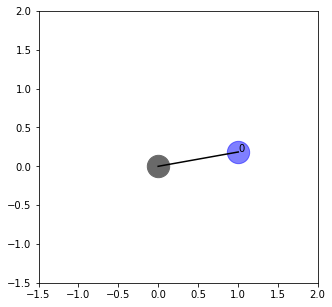

====kernel info====
p_support:
tensor([[ 0.088621, -0.194643],
        [-0.083412, -1.263635]])


x_support:
tensor([[-0.953623],
        [ 0.276748]])


x_center:
tensor([[-2.112568]])


p_center:
tensor([0, 0])


edge_attr_support:
tensor([[-0.584525],
        [ 0.866130],
        [ 0.050883],
        [ 1.161985]])


1-0 angle:28.2564584453969


0 length:0.21386778354644775
1 length:1.2663846015930176


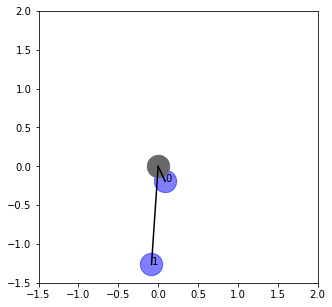

====kernel info====
p_support:
tensor([[-0.040337,  1.432343],
        [-0.834167,  1.008701],
        [-2.585747,  0.209086]])


x_support:
tensor([[-1.399822],
        [-0.419127],
        [ 1.090744]])


x_center:
tensor([[-0.667196]])


p_center:
tensor([0, 0])


edge_attr_support:
tensor([[-0.271311],
        [-0.803051],
        [-1.044476],
        [-1.587452],
        [-0.424607],
        [ 1.506662]])


1-0 angle:37.97665433249837
2-0 angle:83.76394416960814
2-1 angle:45.787286422015185


0 length:1.432910680770874
1 length:1.308935284614563
2 length:2.594186782836914


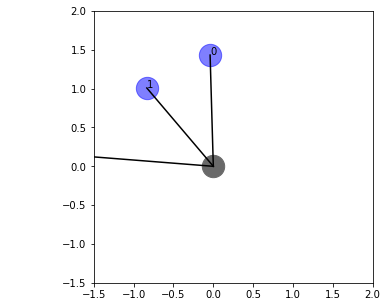

====kernel info====
p_support:
tensor([[-0.033583, -1.732469],
        [-1.014960, -0.130584],
        [ 1.023490, -0.003352],
        [ 0.952216,  0.784402]])


x_support:
tensor([[ 0.527846],
        [ 1.058785],
        [ 0.803053],
        [-0.655210]])


x_center:
tensor([[0.230474]])


p_center:
tensor([0, 0])


edge_attr_support:
tensor([[ 0.376806],
        [ 0.383395],
        [ 0.248256],
        [ 1.126481],
        [ 0.601428],
        [-0.305609],
        [ 1.216490],
        [ 1.806630]])


1-0 angle:81.55816189790922
2-0 angle:90.92284302361693
2-1 angle:172.48101858190446
3-0 angle:130.59097662859605
3-1 angle:147.85086466121825
3-2 angle:39.66812677478994


0 length:1.7327945232391357
1 length:1.0233259201049805
2 length:1.0234953165054321
3 length:1.2336944341659546


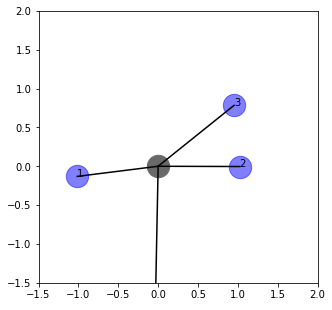

In [328]:
vis_kernel_in_model(model)

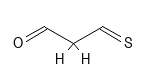
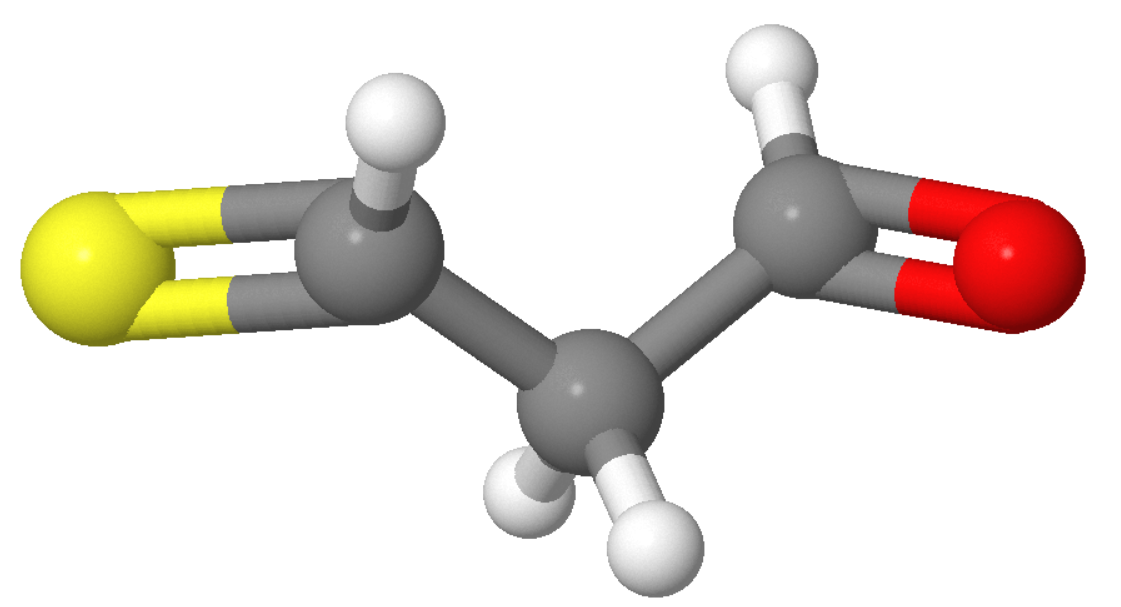

In [ ]:
# test of getting neighbor_index from center_index
import torch
# tensor = torch.randint(15,(2,4), dtype=torch.long)
# print('tensor:')
# print(tensor)

# print('\n')
# print('values')
# values = torch.arange(10, dtype=torch.long)
# print(values)

# print('\n')
# a = tensor[0]

# print(a)
# b = a.unsqueeze(1) == values
# print(b)
# c = b.nonzero()
# print(c)
# d = c[:,0]
# print(d)
# tensor[1,d]


def get_neighbor_index(edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]
    
    return edge_index[1,d]

a = get_neighbor_index(tensor, values)

# print(f'a:{a}')

edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8], [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
print(edge_index)
nei_index = torch.tensor([1,3,8])
print(nei_index)
edge_attr = torch.tensor([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

def get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]

    # normalize bond id
    e = (d/2).long()
    bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
    
    # select bond attributes with the bond id
    nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)
    
    return nei_edge_attr
center_index = torch.tensor([2])

a = get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index)
print(a)